In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN, FCPCNV2
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
subset = 5
dataset = torch.utils.data.Subset(dataset, range(subset))

train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

IndexError: index 5 is out of bounds for dimension 0 with size 5

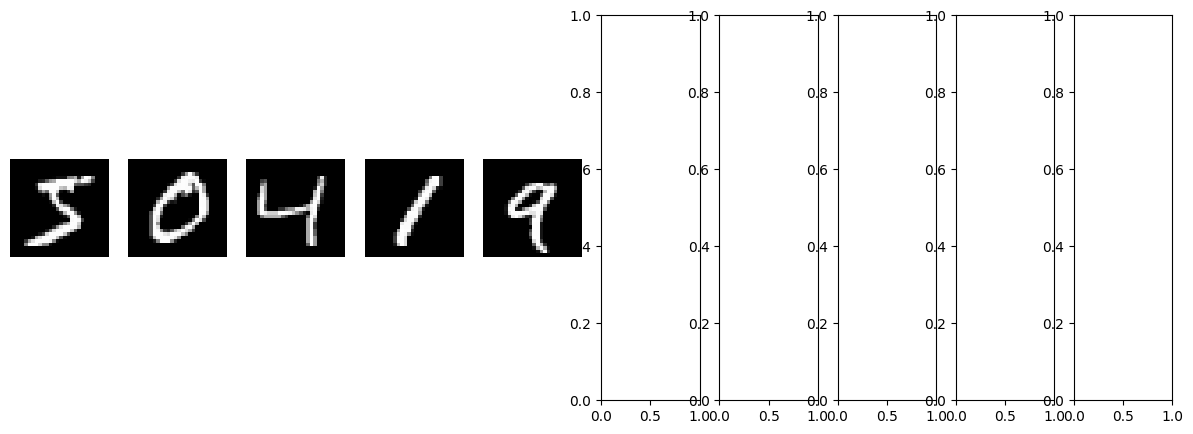

In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [5]:
all_stats = {}

In [10]:
def train(
        model,
        BATCH_SIZE,
        NUM_EPOCHS,
        train_dataset,
        optimiser,
        scheduler,
        stats,
        eval_every=500,
        norm_grads=False,
        neg_steps=0,
):

    pos_x = train_dataset.transformed_images.clone().flatten(1)

    loop = tqdm(range(NUM_EPOCHS), leave=False)

    for i in loop:
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        # TQDM loop
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'VFE': stats['Vfe'][-1], 'posVFE': stats['posVfe'][-1], 'negVFE': stats['negVfe'][-1]})

        # Epoch stats
        epochVfes = []
        epochPosVfes = []
        epochNegVfes = []


        # Iterate over all batches
        model.train()
        # neg_x = pos_x.clone() + torch.randn_like(pos_x) * 0.3
        neg_x = pos_x.clone()
        neg_x[torch.rand_like(neg_x) < 0.5] = 0.0
        _, pos_state = model(pos_x, pin_obs=True)
        _, neg_state = model(neg_x, pin_obs=True, steps=neg_steps)


        with torch.no_grad():
            pos_vfe = model.vfe(pos_state, normalise=False)
            neg_vfe = model.vfe(neg_state, normalise=False)

        # # cross_state has xs from pos_state, and preds from neg_state
        # cross_state = [{k: v.detach().clone() for k, v in state_l.items()} for state_l in pos_state]
        # for i in range(len(model.layers)):
        #     if i < len(model.layers) - 1:
        #         pred = model.layers[i+1].predict(neg_state[i+1])
        #     else:
        #         pred = model.top.predict(neg_state[i])
        #     cross_state[i]['e'] = F.normalize(cross_state[i]['x'], 1) - F.normalize(pred, 1)
        #     # cross_state[i]['e'] = cross_state[i]['x'] - pred
        # vfe = model.vfe(cross_state, normalise=norm_grads)

        # for i in range(len(model.layers)):
        #     if i < len(model.layers) - 1:
        #         pred = model.layers[i+1].predict(neg_state[i+1])
        #     else:
        #         pred = model.top.predict(neg_state[i])
        #     # pos_state[i]['e'] = F.normalize(pos_state[i]['x'], 1) - F.normalize(pred, 1)
        #     pos_state[i]['e'] = pos_state[i]['x'] - pred
        # vfe = model.vfe(pos_state, normalise=norm_grads)
        
        # for i in range(len(model.layers)):
        #     if i < len(model.layers) - 1:
        #         pred = model.layers[i+1].predict(pos_state[i+1])
        #     else:
        #         pred = model.top.predict(pos_state[i], abs=True)
        #     # pos_state[i]['e'] = F.normalize(pos_state[i]['x'], 1) - F.normalize(pred, 1) pos_state[i]['e'] = pos_state[i]['x'] - pred
        # vfe = model.vfe(pos_state, normalise=norm_grads)

        for i in range(len(model.layers)):
            if i < len(model.layers) - 1:
                pred = model.layers[i+1].predict(pos_state[i+1])
            else:
                pred = model.top.predict_w_dropout(pos_state[i])
            pos_state[i]['e'] = pos_state[i]['x'] - pred
        vfe = model.vfe(pos_state, normalise=norm_grads)

        # Update model parameters
        optimiser.zero_grad()
        loss = vfe

        loss.backward()
        optimiser.step()

        # if norm_grads, recalculate VFE WITHOUT normalisation for plotting (otherwise it will be constant)
        if norm_grads:
            # vfe = model.vfe(cross_state, normalise=False)
            vfe = model.vfe(pos_state, normalise=False)

        epochVfes.append(vfe.item())
        epochPosVfes.append(pos_vfe.item())
        epochNegVfes.append(neg_vfe.item())

        # Track epoch stats
        stats['posVfe'].append(torch.tensor(epochPosVfes).mean().item())
        stats['negVfe'].append(torch.tensor(epochNegVfes).mean().item())
        stats['Vfe'].append(torch.tensor(epochVfes).mean().item())

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['Vfe'][-1])
        
        stats['epoch'] += 1
    
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.001)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'valAcc': stats['valAcc'][-1], 'valLoss': stats['valLoss'][-1]})

        # Iterate over all batches
        for (images, labels) in loop:
            images = images.flatten(1)

            out, state = model(images)
            out = classifier(out)

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])
        
        stats['epoch'] += 1

In [17]:
torch.manual_seed(seed)

model_name = 'original'
model = FCPCNV2(
    sizes=[INPUT_SHAPE, 600, 600, 20],
    # sizes = [INPUT_SHAPE,],
    bias=True, 
    symmetric=False,
    actv_fn=F.relu,
    steps=20,
    gamma=0.5,
    x_decay=0.0,
    dropout=0.2,
).to(device)
stats = {
    'epoch': 0,
    'Vfe': [],
    'posVfe': [],
    'negVfe': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}

In [18]:
BATCH_SIZE = 5
NUM_EPOCHS = 600
# optimiser = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.02)
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)
train(
    model,
    BATCH_SIZE,
    NUM_EPOCHS,
    train_dataset,
    optimiser,
    # scheduler,
    None,
    stats,
    25,
    norm_grads=False,
    neg_steps=1,
)

In [19]:
all_stats['classic'] = stats

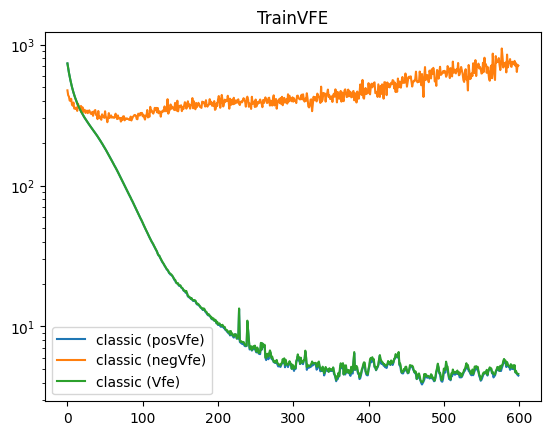

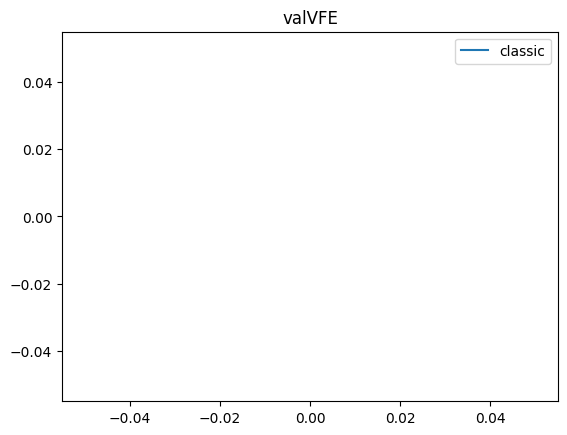

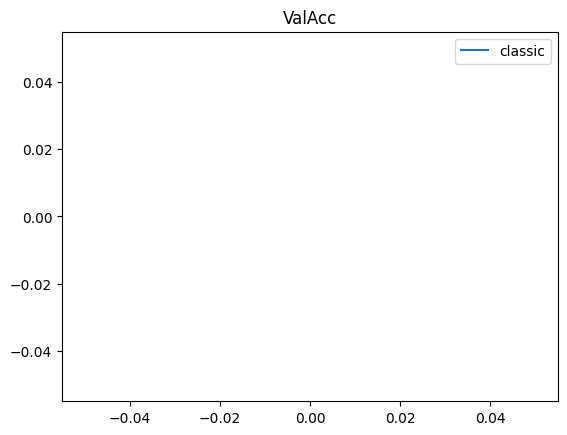

In [20]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k+' (posVfe)')
    plt.plot(v['negVfe'], label=k+' (negVfe)')
    plt.plot(v['Vfe'], label=k+' (Vfe)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valVfe'], label=k)
plt.legend()
plt.title('valVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valAcc'], label=k)
plt.legend()
plt.title('ValAcc')
# plt.yscale('log')
plt.show()

In [58]:
model.eval()
x = train_dataset.transformed_images[10].flatten(1)
out, state = model(x, pin_obs=True, steps=50)
model.vfe(state)

tensor(527.7679, device='cuda:0')

In [18]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(20, 10),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'valAcc': [],
    'valLoss': [],
}

In [19]:
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    # eval_every=10,
)

KeyboardInterrupt: 

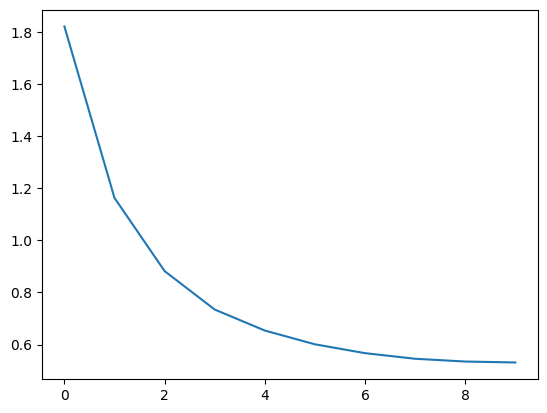

In [20]:
plt.plot(class_stats['trainLoss'], label='trainLoss')

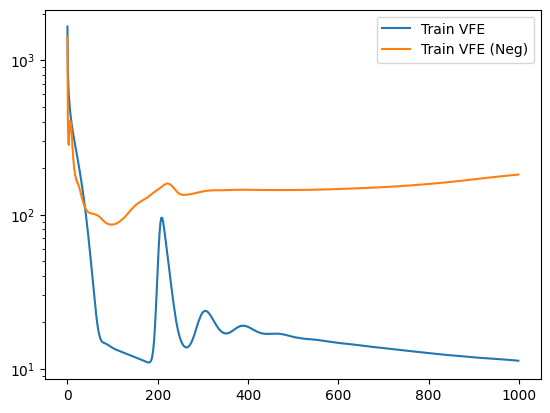

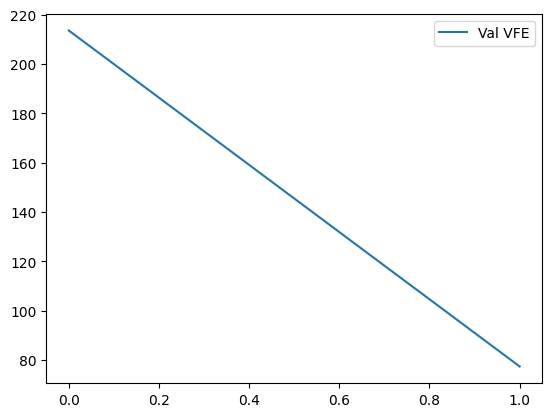

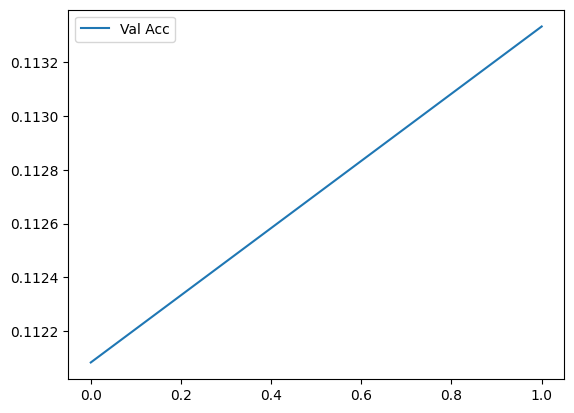

In [11]:
plt.plot(stats['trainVfe'], label='Train VFE')
plt.plot(stats['negVfe'], label='Train VFE (Neg)')
# plt.plot(sameneg_stats['trainVfe'], label='Train VFE (Neg)')
# plt.plot(noneg_nonorm_stats['trainVfe'], label='Train VFE (No Norm)')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(stats['valVfe'], label='Val VFE')
# plt.plot(stats['valVfe'], label='Val VFE (Neg)')
# plt.plot(noneg_nonorm_stats['valVfe'], label='Val VFE (No Norm)')
plt.legend()
plt.show()

plt.plot(stats['valAcc'], label='Val Acc')
# plt.plot(sameneg_stats['valAcc'], label='Val Acc (Neg)')
# plt.plot(noneg_nonorm_stats['valAcc'], label='Val Acc (No Norm)')
plt.legend()
plt.show()

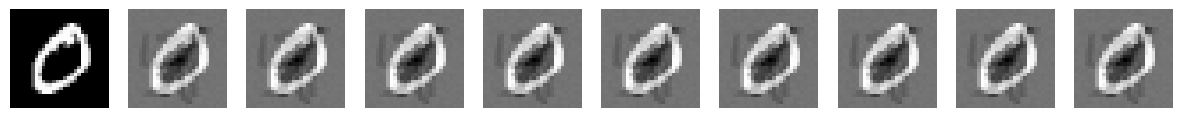

In [20]:
x = train_dataset.images[1].flatten(1).clone()
# x += torch.randn_like(x) * 0.8
# x[torch.rand_like(x) > 0.6] = 0.0
model.eval()

# vfes = []
# x = train_dataset.transformed_images[1].flatten(1)
# state = model.init_state(x)
# # gamma = torch.ones(BATCH_SIZE, device=device) * 0.2
# gamma = torch.ones(1, device=device) * 0.2
# for i in range(100):
#     model.step(state, gamma, pin_obs=True)
#     if i > 50: 
#         vfes.append(model.vfe(state, normalise=False).item())
#         if len(vfes) > 2 and vfes[-1] > vfes[-2]:
#             gamma *= 0.8

# plt.plot(vfes)
# plt.yscale('log')

# state[0]['x'] += torch.randn_like(state[0]['x']) * 100

fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    out, state = model.reconstruct(x.unsqueeze(0), steps=50)
    if i == 0:
        ax[i].imshow(x.cpu().detach().numpy().reshape(28, 28), cmap='gray')
    else:
        ax[i].imshow(out[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    ax[i].axis('off')

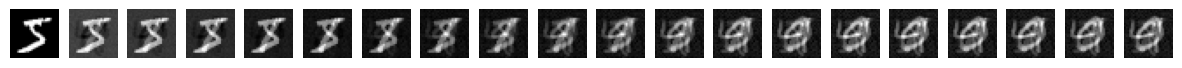

In [21]:
idx = 0
state = model.init_state(train_dataset.transformed_images[idx].flatten(1))


fig, axes = plt.subplots(1, 20, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = state[0]['x'][0].cpu().detach().numpy().reshape(28, 28)
    for _ in range(50):
        model.step(state, torch.ones(BATCH_SIZE, device=device) * 0.2, pin_obs=False)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

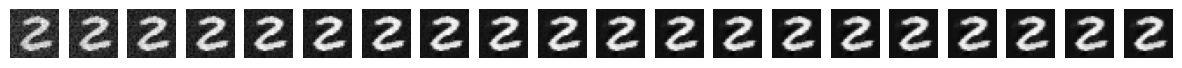

In [38]:
copy_dic = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_states[0]]
copy_dic[0]['x'] += torch.randn_like(copy_dic[0]['x']) * 0.3

state = model.init_state(copy_dic[0]['x'])

fig, axes = plt.subplots(1, 20, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = state[0]['x'][0].cpu().detach().numpy().reshape(28, 28)
    # for _ in range(50):
    model.step(state, torch.ones(BATCH_SIZE, device=device) * 0.2, pin_obs=False)
    # out, state = model.reconstruct(state[0]['x'], steps=50)
    # state[0]['x'] = out
    ax.imshow(img, cmap='gray')
    ax.axis('off')

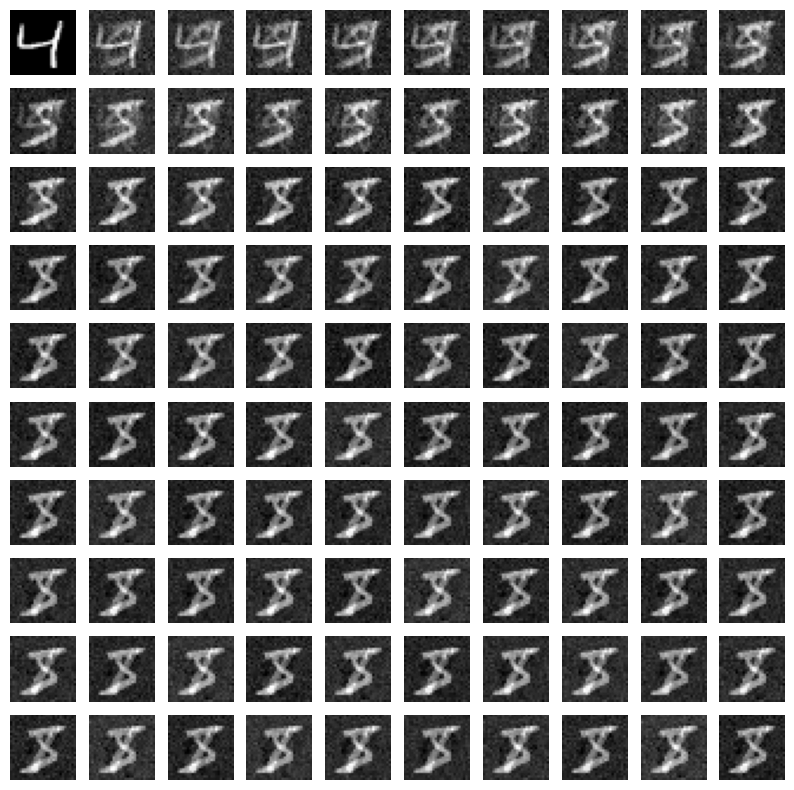

In [25]:
model.eval()
x = train_dataset.images[2].flatten(1).clone()
x += torch.randn_like(x) * 0.0
# x[torch.rand_like(x) > 0.8] = 0.0


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = x.cpu().reshape(28,28).detach()
        ax2.imshow(img, cmap='gray')
        x, _ = model.reconstruct(x, steps=2)
        ax2.axis('off')

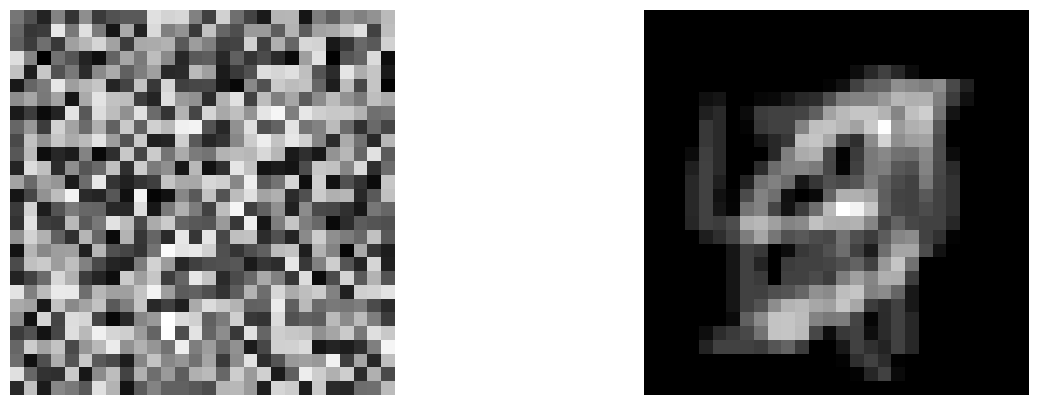

In [61]:
img = model.layers[1].bias.data.cpu().numpy()
mean = train_dataset.transformed_images.mean(0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img.reshape(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(mean.cpu().numpy().reshape(28, 28), cmap='gray')
axes[1].axis('off')

plt.show()
